# True Reach Estimator

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# TRIAL 10

Curvilinear
- Import the data
- Use descriptive tools to determine which columns to keep in the data
- Create plots to show outliers and noise in our data to make decisions about how to further clean
- Set conditions on the data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the perdiction 
- Use the regression model to plot an interaction chart to see if our features will work together to predict
- Summarize our findings and suggest next steps if unsucessful

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

Pull in the CSV file

In [2]:
df = pd.read_csv('Impression-estimator-data.csv')

Add column labels

In [3]:
df.columns = ['user_id', 'instagram_id', 'followers', 'published', 'likes', 'comments', 'impressions', 'reach', 'saves']

First, look at the data

In [4]:
df.head()
df.user_id.nunique()

5093

In [5]:
df.head()

,user_id,instagram_id,followers,published,likes,comments,impressions,reach,saves
0,23453,1804097511021850960_2093269988,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782,2
1,23453,1803896519311250817_2093269988,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131,5
2,23453,1804851140192245591_2093269988,68223,2018-06-19T02:24:03.000+00:00,38,1,290,261,3
3,23453,1804559396443658465_2093269988,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082,30
4,23453,1790384884076531376_2093269988,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215,119


In [6]:
len(df)

728018

Drop columns that are unneeded.

In [7]:
df2 = df.drop(['user_id', 'instagram_id', 'saves'], axis=1)

In [8]:
df2.head()

,followers,published,likes,comments,impressions,reach
0,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782
1,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131
2,68223,2018-06-19T02:24:03.000+00:00,38,1,290,261
3,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082
4,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215


## Create histograms of our three variables to check for normality. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


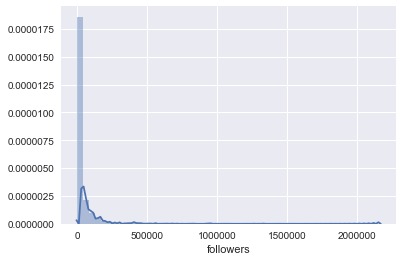

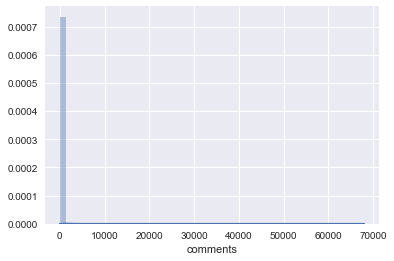

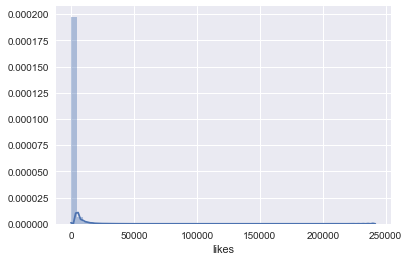

In [9]:
sns.distplot(df2.followers)
plt.show()
sns.distplot(df2.comments)
plt.show()
sns.distplot(df2.likes)
plt.show()

### findings: 
- Clearly our data variables are not normally distributed and skew to the left. We will try to exclude some of our data to determine if we can see these random variables more evenly distributed. 

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 300.

In [10]:
df2 = df2[(df2['reach']>300)]

Next we decided to remove rows that have less than 1000 followers. This not only helps eliminate outliers but in the data collection there were many rows with exactly zero followers yet high numbers in reach. This data clearly is not correct or not in the style we are looking for. 

In [11]:
df2 = df2[(df2['followers']>1000)]

Setting comments to greater than zero to avoid zero division errors

In [12]:
df2 = df2[(df2['comments']>=2)]

Remove rows with less than 100 likes to eliminate outliers.

In [13]:
df2 = df2[(df2['likes']>=100)]

Remove wierd situations where there are more comments or likes than reach.

In [14]:
df2 = df2.loc[(df2.likes<df2.reach)]
df2 = df2.loc[(df2.comments<df2.reach)]

Now, what does our data look like? 

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445966 entries, 3 to 728011
Data columns (total 6 columns):
followers      445966 non-null int64
published      445966 non-null object
likes          445966 non-null int64
comments       445966 non-null int64
impressions    445966 non-null int64
reach          445966 non-null int64
dtypes: int64(5), object(1)
memory usage: 23.8+ MB


# Multicollinearity Of Features

Next we look at full correlation. The test here is to make sure that any two of our variables aren't so correlated that the account for the same effect on the dependent variable.

In [16]:
df2.corr()

,followers,likes,comments,impressions,reach
followers,1.000000,0.684169,0.172749,0.583892,0.568056
likes,0.684169,1.000000,0.272195,0.809445,0.790719
comments,0.172749,0.272195,1.000000,0.207635,0.197952
impressions,0.583892,0.809445,0.207635,1.000000,0.994968
reach,0.568056,0.790719,0.197952,0.994968,1.000000


We then created a heat map of the correation numbers to better see which variables we can use. 

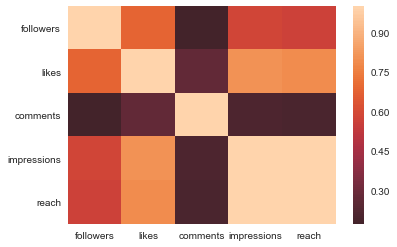

In [17]:
sns.heatmap(df2.corr(), center=0);

Curious to see the time frame of these records. 

In [18]:
print(df2.published.astype('<M8[D]').min())
print(df2.published.astype('<M8[D]').max())

2017-04-18 00:00:00
2018-06-25 00:00:00


We started by testing the coefficents against 'reach' with SKlearn. This module has a linear regression method. 

In [19]:
x = df2[['followers','likes','comments']]
y = df2.reach

In [20]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
clf.coef_

array([ 0.01598377,  8.53759536, -3.24546133])

In [22]:
type(clf)

sklearn.linear_model.base.LinearRegression

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [23]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                 2.498e+05
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:20:45   Log-Likelihood:            -5.0512e+06
No. Observations:              445966   AIC:                         1.010e+07
Df Residuals:                  445962   BIC:                         1.010e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1195.3766     34.687    -34.462      0.000   -1263.362   -1127.391
followers      0.0160      0.000     40.211      0.000       0.015       0.017
likes          8.5376      0.014    592.765      0.000       8.509       8.566
comments      -3.2455      0.172    -18.855      0.000      -3.583      -2.908
==============================================================================
Omnibus:                  1185106.275   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     168578713435.460
Skew:                          31.160   Prob(JB):                         0.00
Kurtosis:                    3014.363   Cond. No.                     1.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots 
- Next we looked at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers Correlation plot')

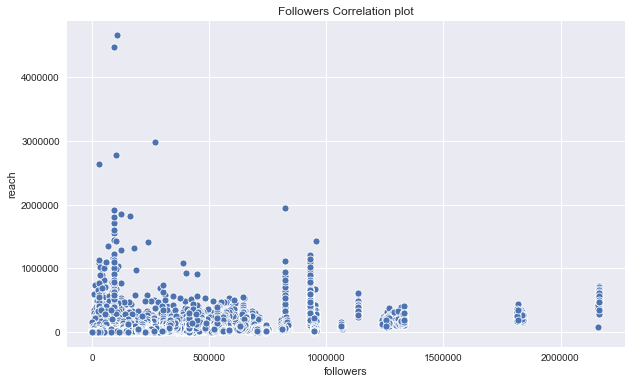

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")
# plt.xlim(0,75_000)
# plt.ylim(0, 1_000_000)

Text(0.5, 1.0, 'Likes Correlation plot')

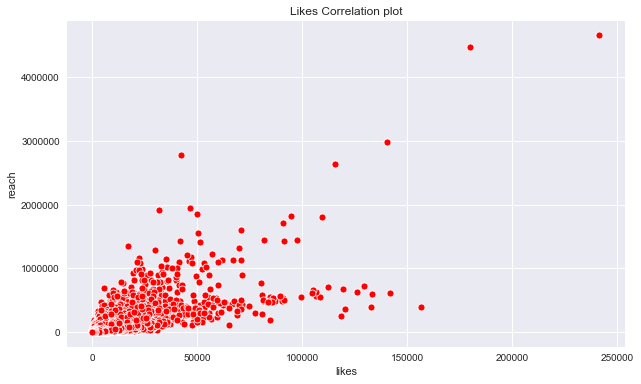

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='Red')
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

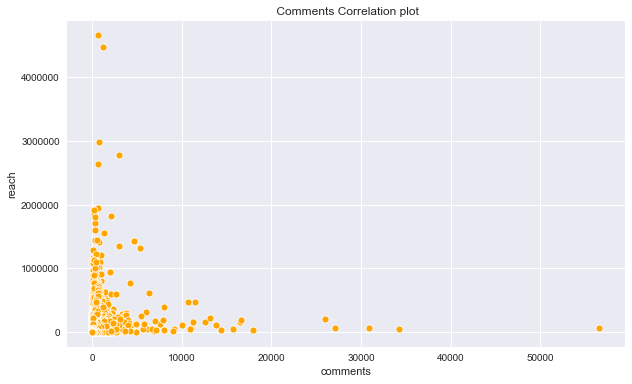

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.comments, color='orange')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

**Findings:**
Our comments plot shows an opportunity to try a curvilinear regression line for the comments variable. 

## Remove extra large users. 

In [27]:
df2 = df2[(df2['followers']<75000)]
df2 = df2[(df2['likes']<75000)]
df2 = df2[(df2['comments']<10000)]

Now that we have cut the top end outliers, Lets run the scatterplots again and models. 

Text(0.5, 1.0, 'Followers Correlation plot')

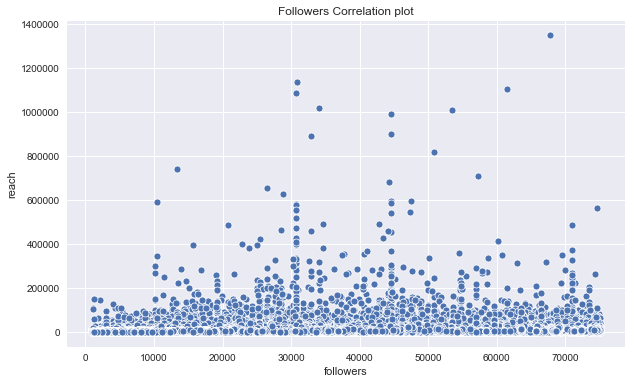

In [28]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")

Text(0.5, 1.0, 'Likes Correlation plot')

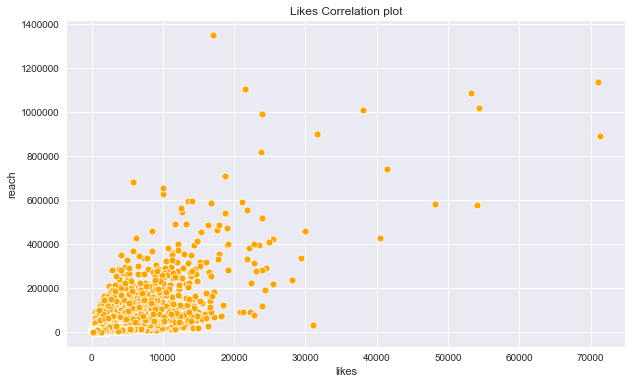

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

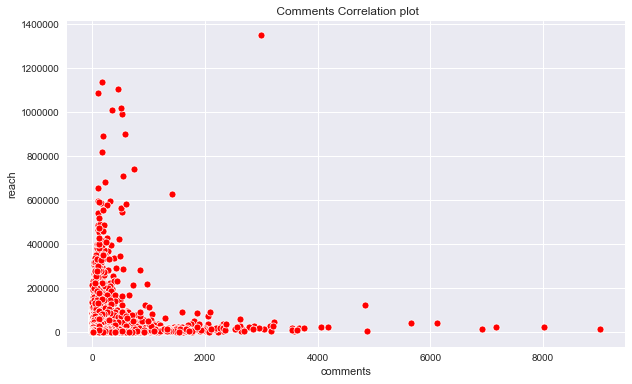

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

**Findings:**
Our new scatterplots without the extra large users. This has helped some, but not likely enough. We will fit a model again and check for accuracy. 

# Add a curvilinear column

In [31]:
df2['comments_squared'] = df2['comments'] **2

In [46]:
from sklearn.preprocessing import PolynomialFeatures

In [32]:
x = df2[['comments',"comments_squared"]]
reg_q = LinearRegression().fit(x, df2['reach'])

TypeError: tuple indices must be integers or slices, not str

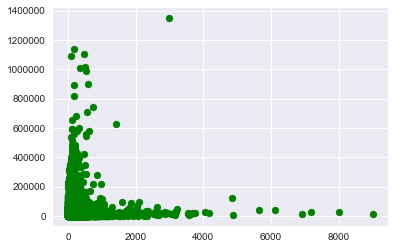

In [47]:
plt.scatter(df2["comments"], df2['reach'], color = "green")

X_pred = pd.DataFrame(np.linspace(0,10000,362501), columns = ["temp"])
X_pred["sq"] = X_pred**2 
y_pred = reg_q.predict(X_pred)
plt.plot(x['comments'], reg_q.predict(x))
plt.xlabel("comments")
plt.ylabel("Reach");

In [34]:
lr_model = ols(formula='reach~comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:21:15   Log-Likelihood:            -3.9221e+06
No. Observations:              362501   AIC:                         7.844e+06
Df Residuals:                  362499   BIC:                         7.844e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4355.3431     22.797    191.049      0.000    4310.662    4400.025
comments      29.6988      0.275    108.007      0.000      29.160      30.238
==============================================================================
Omnibus:                   945893.825   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      55431816265.860
Skew:                          30.109   Prob(JB):                         0.00
Kurtosis:                    1917.767   Cond. No.                         94.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
lr_model = ols(formula='reach~comments_squared', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     525.1
Date:                Fri, 08 Mar 2019   Prob (F-statistic):          4.04e-116
Time:                        14:21:16   Log-Likelihood:            -3.9276e+06
No. Observations:              362501   AIC:                         7.855e+06
Df Residuals:                  362499   BIC:                         7.855e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5506.6165     20.403    269.899      0.000    5466.628    5546.605
comments_squared     0.0018   8.03e-05     22.914      0.000       0.002       0.002
==============================================================================
Omnibus:                   948805.683   Durbin-Watson:                   1.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      56748468682.215
Skew:                          30.350   Prob(JB):                         0.00
Kurtosis:                    1940.381   Cond. No.                     2.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
lr_model = ols(formula='reach~comments+comments_squared', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     7911.
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:21:16   Log-Likelihood:            -3.9201e+06
No. Observations:              362501   AIC:                         7.840e+06
Df Residuals:                  362498   BIC:                         7.840e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3809.3483     24.249    157.091      0.000    3761.820    3856.876
comments            44.7903      0.362    123.589      0.000      44.080      45.501
comments_squared    -0.0066      0.000    -63.455      0.000      -0.007      -0.006
==============================================================================
Omnibus:                   949528.882   Durbin-Watson:                   1.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      57209832216.358
Skew:                          30.409   Prob(JB):                         0.00
Kurtosis:                    1948.245   Cond. No.                     3.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
lr_model = ols(formula='reach~followers+likes+comments+comments_squared', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                 9.373e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:21:16   Log-Likelihood:            -3.7991e+06
No. Observations:              362501   AIC:                         7.598e+06
Df Residuals:                  362496   BIC:                         7.598e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1264.0783     23.541    -53.697      0.000   -1310.218   -1217.939
followers            0.0025      0.001      2.900      0.004       0.001       0.004
likes                9.5778      0.018    529.678      0.000       9.542       9.613
comments           -12.1064      0.277    -43.686      0.000     -12.650     -11.563
comments_squared     0.0025   7.62e-05     32.656      0.000       0.002       0.003
==============================================================================
Omnibus:                   949688.624   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      88425046023.025
Skew:                          30.184   Prob(JB):                         0.00
Kurtosis:                    2421.819   Cond. No.                     4.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Save clean CSV to new file for use on other notebooks.

In [38]:
#df2.to_csv('clean_instagram_train.csv')
#test.to_csv('clean_instagran_test.csv')

## Early Tests

Create a quick function to run the coefficients from the three variables. 

### Add Test Reach to the original data Frame to check for accuracy

In [39]:
df2['test_reach'] = lr_model.predict(df2)

In [40]:
df2['reach_diff'] = df2['reach'] - df2['test_reach']

In [41]:
df2['diff_ratio'] = (df2.reach_diff / df2.reach)*100

Text(0, 0.5, 'Count')

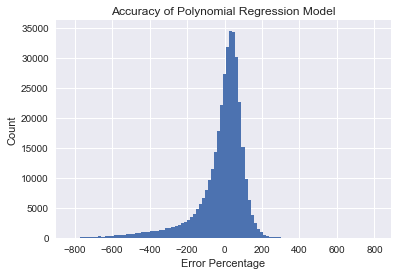

In [42]:
x = plt.hist(df2.diff_ratio, bins = 100)
plt.title('Accuracy of Polynomial Regression Model')
plt.xlabel('Error Percentage')
plt.ylabel('Count')

In [43]:
mean_squared_error(df2.reach, df2.test_reach)**.5

8615.569429252777

## Interactions.
Lets create a plot to see if the three variables are interacting with each other in the model. 

In [44]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[9.3528]
[29.69876137]
[0.21361098]


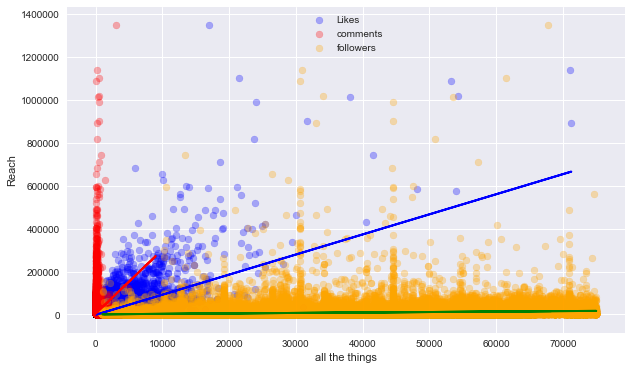

In [45]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of Trial 10

